In [1]:
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt

In [2]:
img_path = "./face_database/A/image1.jpg"

In [3]:
img = cv2.imread(img_path)

In [4]:
obj = RetinaFace.detect_faces(img_path)

25-09-08 19:58:13 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /Users/prachitdeshinge/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:46<00:00, 2.53MB/s] 


In [5]:
len(obj.keys())

1

In [6]:
for key in obj.keys():
    identity = obj[key]
    facial_area = identity["facial_area"]
    x1, y1, x2, y2 = facial_area
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

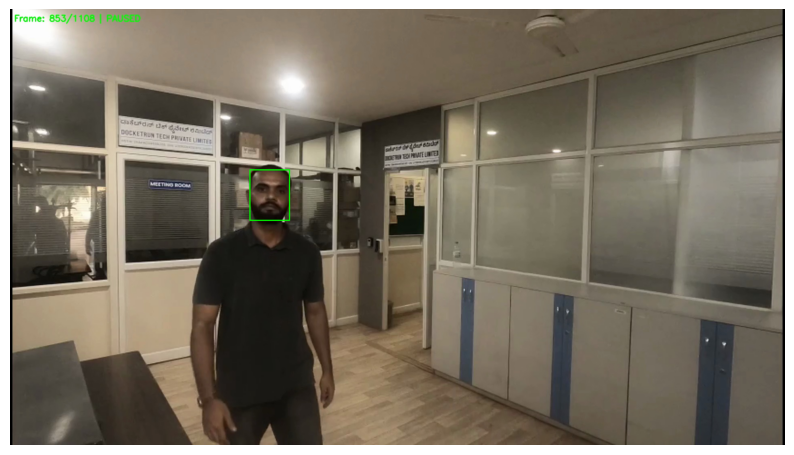

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.show()

In [8]:
from deepface import DeepFace

In [10]:
obj = DeepFace.verify(img1_path = "./face_database/A/image1.jpg", img2_path = "./face_database/A/image2.jpg", model_name = 'ArcFace', detector_backend = 'retinaface')

In [11]:
obj

{'verified': True,
 'distance': 0.271262,
 'threshold': 0.68,
 'confidence': 87.83,
 'model': 'ArcFace',
 'detector_backend': 'retinaface',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 596,
   'y': 400,
   'w': 96,
   'h': 125,
   'left_eye': (670, 450),
   'right_eye': (624, 447),
   'nose': (648, 468),
   'mouth_left': (664, 494),
   'mouth_right': (627, 492)},
  'img2': {'x': 765,
   'y': 377,
   'w': 124,
   'h': 163,
   'left_eye': (862, 443),
   'right_eye': (803, 438),
   'nose': (833, 467),
   'mouth_left': (852, 501),
   'mouth_right': (805, 497)}},
 'time': 3.95}

In [ ]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from deepface import DeepFace
from deepface.modules.verification import find_cosine_distance
from google.colab.patches import cv2_imshow  # For displaying frames in Colab
from IPython.display import clear_output  # For clearing output in Colab

# Load your face database
def load_database(file_path):
    if os.path.exists(file_path):
        return pd.read_pickle(file_path)
    else:
        print(f"Database file {file_path} not found.")
        return None

# Identify a face from an image frame
def identify_face(frame, database_df, model_name="Facenet512", detector_backend="retinaface"):
    try:
        # Convert frame to RGB (DeepFace uses RGB)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Find faces in the frame
        embedding_objs = DeepFace.represent(
            img_path=rgb_frame,
            model_name=model_name,
            detector_backend=detector_backend,
            enforce_detection=False,
            align=True  # Align faces for better accuracy
        )
        
        results = []
        for embedding_obj in embedding_objs:
            if "embedding" in embedding_obj:
                source_embedding = embedding_obj["embedding"]
                facial_area = embedding_obj["facial_area"]
                
                identities = []
                for idx, row in database_df.iterrows():
                    distance = find_cosine_distance(source_embedding, row["embedding"])
                    identities.append({
                        "identity": row["identity"],
                        "distance": distance,
                        "db_image_path": row["image_path"]
                    })
                
                if identities:
                    best_match = min(identities, key=lambda x: x["distance"])
                    
                    # Model-specific thresholds
                    thresholds = {
                        "VGG-Face": 0.68, 
                        "Facenet": 0.4, 
                        "Facenet512": 0.3,
                        "OpenFace": 0.1,
                        "DeepID": 0.015,
                        "ArcFace": 0.68,
                        "SFace": 0.593,
                        "GhostFaceNet": 0.65
                    }
                    
                    threshold = thresholds.get(model_name, 0.4)
                    verified = best_match["distance"] <= threshold
                    
                    # Calculate confidence score
                    if verified:
                        confidence = 100 * (1 - (best_match["distance"] / threshold))
                    else:
                        confidence = 100 * (threshold / best_match["distance"]) if best_match["distance"] > 0 else 0
                    
                    confidence = max(0, min(100, confidence))
                    
                    results.append({
                        "facial_area": facial_area,
                        "best_match": best_match["identity"],
                        "distance": best_match["distance"],
                        "threshold": threshold,
                        "verified": verified,
                        "confidence": confidence,
                        "db_image_path": best_match["db_image_path"]
                    })
        
        return results
        
    except Exception as e:
        print(f"Identification error: {e}")
        return []

# Main function for video file face recognition
def video_face_recognition():
    # Configuration
    MODEL_NAME = "ArcFace"        # You can try "SFace" for faster performance
    DETECTOR_BACKEND = "mtcnn"    # Using MTCNN for better speed
    
    # Load the face database
    db_df = load_database("face_database.pkl")
    if db_df is None:
        print("Please create the face database first.")
        return
    
    # Initialize video capture
    video_path = '/content/03_09_2025_face_recognition.mp4'
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}.")
        return
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # For FPS calculation
    prev_time = 0
    curr_time = 0
    frame_count = 0
    
    print("Starting video face recognition. Processing will take some time...")
    
    # Process the video
    while True:
        # Read frame from video
        ret, frame = cap.read()
        if not ret:
            print("Finished processing video.")
            break
        
        frame_count += 1
        
        # Skip frames to speed up processing (process every 5th frame)
        if frame_count % 5 != 0:
            continue
        
        # Calculate FPS
        curr_time = time.time()
        processing_fps = 1 / (curr_time - prev_time) if prev_time > 0 else 0
        prev_time = curr_time
        
        # Identify faces in the frame
        results = identify_face(frame, db_df, MODEL_NAME, DETECTOR_BACKEND)
        
        # Draw results on the frame
        for result in results:
            x, y, w, h = result["facial_area"]["x"], result["facial_area"]["y"], \
                         result["facial_area"]["w"], result["facial_area"]["h"]
            
            # Draw bounding box
            color = (0, 255, 0) if result["verified"] else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            # Prepare label text
            if result["verified"]:
                label = f"{result['best_match']} ({result['confidence']:.1f}%)"
            else:
                label = "Unknown"
            
            # Draw label background
            cv2.rectangle(frame, (x, y - 25), (x + w, y), color, -1)
            
            # Draw label text
            cv2.putText(frame, label, (x, y - 5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Display FPS and progress
        progress = (frame_count / total_frames) * 100
        cv2.putText(frame, f"FPS: {processing_fps:.1f}", (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Progress: {progress:.1f}%", (10, 60), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Model: {MODEL_NAME}", (10, 90), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Display the frame in Colab
        # Resize for better display in Colab
        display_frame = cv2.resize(frame, (800, 450))
        cv2_imshow(display_frame)
        clear_output(wait=True)  # Clear previous frame
        
        # Exit on 'q' key press (not really needed in Colab, but kept for consistency)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Clean up
    cap.release()
    print("Video processing completed.")

# Alternative: Save processed video to file
def process_and_save_video():
    # Configuration
    MODEL_NAME = "ArcFace"
    DETECTOR_BACKEND = "retinaface"
    
    # Load the face database
    db_df = load_database("/content/face_database_ArcFace.pkl")
    if db_df is None:
        print("Please create the face database first.")
        return
    
    # Initialize video capture
    video_path = '/content/03_09_2025_face_recognition.mp4'
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}.")
        return
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Define the codec and create VideoWriter object
    output_path = '/content/processed_video.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    print("Processing and saving video. This may take a while...")
    
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Process every 5th frame to save time
        if frame_count % 2 == 0:
            results = identify_face(frame, db_df, MODEL_NAME, DETECTOR_BACKEND)
            
            # Draw results on the frame
            for result in results:
                x, y, w, h = result["facial_area"]["x"], result["facial_area"]["y"], \
                             result["facial_area"]["w"], result["facial_area"]["h"]
                
                color = (0, 255, 0) if result["verified"] else (0, 0, 255)
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                
                if result["verified"]:
                    label = f"{result['best_match']} ({result['confidence']:.1f}%)"
                else:
                    label = "Unknown"
                
                cv2.rectangle(frame, (x, y - 25), (x + w, y), color, -1)
                cv2.putText(frame, label, (x, y - 5), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Write the frame to output video
        out.write(frame)
        
        # Show progress
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames...")
    
    # Clean up
    cap.release()
    out.release()
    print(f"Video processing completed. Output saved to {output_path}")

if __name__ == "__main__":
    # Choose one of the following:
    # 1. Process and display in Colab (slower but you can see progress)
    video_face_recognition()
    
    # 2. Process and save to file (faster, then you can download the video)
    # process_and_save_video()